<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
# This link may break due to google changing how files are linked. You can manually download from https://drive.google.com/drive/folders/1BOLGo3CFDa_qJMLRgtTZ6zrAWezk9oJu?usp=sharing
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul
from deepul.hw2_helper import *
from torch import nn
import torch
import tqdm

Cloning into 'deepul'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 270 (delta 51), reused 32 (delta 32), pack-reused 188 (from 2)
Receiving objects: 100% (270/270), 94.71 MiB | 26.72 MiB/s, done.
Resolving deltas: 100% (100/100), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1652  100  1652    0     0   4850      0 --:--:-- --:--:-- --:--:--  4858
[hw2_data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hw2_data.zip or
        hw2_data.zip.zip, and cannot find hw2_data.zip.ZIP, period.
Processing ./deepu

In [ ]:
#down svhn and cifar10 datasets
import torchvision
import torchvision.transforms as transforms

def get_svhn_dataset():
  data_dir = get_data_dir(2)
  train_dataset = torchvision.datasets.SVHN(root=data_dir, split="train", download=True, transform=transforms.ToTensor())
  test_dataset = torchvision.datasets.SVHN(root=data_dir, split="test", download=True, transform=transforms.ToTensor())
  data = {"train": train_dataset.data.transpose((0, 2, 3, 1)), "test": test_dataset.data.transpose(0, 2, 3, 1)}
  with open(join(data_dir, "svhn.pkl"), "wb") as file:
    pickle.dump(data, file)

def get_cifar10_dataset():
  data_dir = get_data_dir(2)
  train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
  test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
  data = {"train": train_dataset.data, "test": test_dataset.data}
  with open(join(data_dir, "cifar10.pkl"), "wb") as file:
    pickle.dump(data, file)

get_svhn_dataset()
get_cifar10_dataset()


100%|██████████| 182M/182M [00:10<00:00, 16.9MB/s]
100%|██████████| 64.3M/64.3M [00:04<00:00, 15.3MB/s]
100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


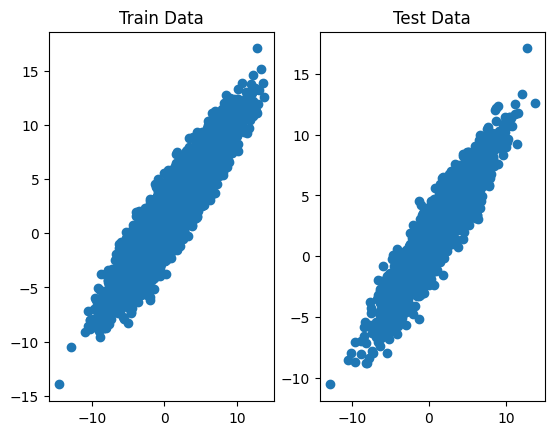

Dataset 2


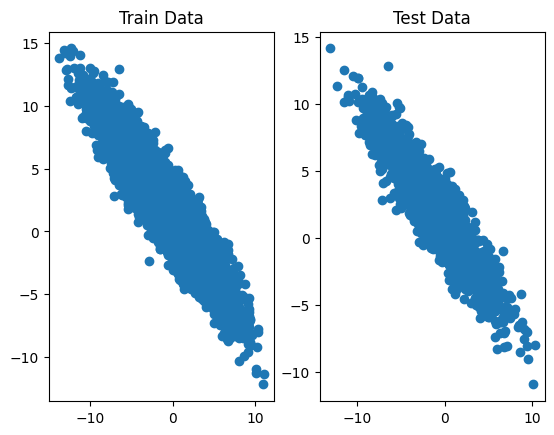

In [ ]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )
        self.mean_pre = nn.Linear(latent_dim, latent_dim)
        self.logstd_pre = nn.Linear(latent_dim, latent_dim)
    def forward(self, x):
        net_out = self.net(x)
        mean_head = net_out[:, :self.latent_dim]
        logstd_head = net_out[:, self.latent_dim:]
        mean = self.mean_pre(mean_head)
        logstd = self.logstd_pre(logstd_head)
        return mean, logstd

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )
        self.mean_head = nn.Linear(latent_dim, 2)
        self.logstd_head = nn.Linear(latent_dim, 2)
    def forward(self, x):
        out = self.net(x)
        mean_head = out[:, :self.latent_dim]
        logstd_head = out[:, self.latent_dim:]
        mean_head = self.mean_head(mean_head)
        logstd_head = self.logstd_head(logstd_head)
        return mean_head, logstd_head
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    epoch = 20
    lr = 1e-3
    bs = 64
    hidden_dim = 128
    latent_dim = 12
    train_data = torch.from_numpy(train_data).float()
    test_data = torch.from_numpy(test_data).float()
    train_set = torch.utils.data.TensorDataset(train_data)
    test_set = torch.utils.data.TensorDataset(test_data)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False)
    encoder = Encoder(hidden_dim, latent_dim)
    decoder = Decoder(hidden_dim, latent_dim)
    train_curves = []
    test_curves = []
    def re_param(x, log_var):
      return x + torch.pow(torch.exp(log_var), 0.5) * torch.randn_like(x)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    def eval_test(model, dataloader):
      with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        total_rec = 0
        total_kl = 0
        for x in test_loader:
          x = x[0]
          mean, logvar = model(x)
          z = mean + torch.pow(torch.exp(logvar), 0.5) * torch.randn_like(mean)
          mean_, log_var_ = decoder(z)
          reconstruct_loss = torch.mean((x - mean_) ** 2)
          kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
          loss = reconstruct_loss + kl_loss
          total_loss += loss.item()
          total_rec += reconstruct_loss.item()
          total_kl += kl_loss.item()
        return (total_loss / len(dataloader), total_kl / len(dataloader), total_rec / len(dataloader))

    for i in tqdm.tgrange(epoch):
      encoder.train()
      decoder.train()
      for x in train_loader:
        x = x[0]

        optimizer.zero_grad()
        mean, logvar = encoder(x)
        z = mean + torch.pow(torch.exp(logvar), 0.5) * torch.randn_like(mean)
        mean_, log_var_ = decoder(z)
        recon_loss = torch.mean((x - mean_) ** 2)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_curves.append((loss.item(),
                  recon_loss.item(),
                  kl_loss.item()))
      test_loss, test_kl, test_rec = eval_test(encoder, test_loader)
      test_curves.append((test_loss, test_kl, test_rec))
    with torch.no_grad():
      encoder.eval()
      decoder.eval()
      input_data = torch.randn(1000, latent_dim)
      # no noise
      with torch.no_grad():
        mean, log_var = decoder(input_data)
        with_out_noise = mean.cpu().numpy()
      # with noise
      with torch.no_grad():
        mean, log_var = decoder(input_data)
        with_noise = (mean + torch.pow(torch.exp(log_var), 0.5) * torch.randn_like(mean)).cpu().numpy()
      print(np.array(test_curves).shape)
      return np.array(train_curves), np.array(test_curves), with_out_noise, with_noise





### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.12/dist-packages/tqdm/gui.py:174: TqdmExperimentalWarning: GUI is experimental/alpha
  return tqdm_gui(range(*args), **kwargs)


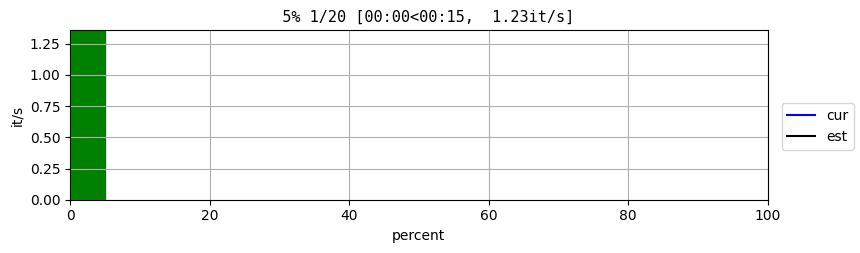

(20, 3)
Final -ELBO: 0.4335, Recon Loss: 0.3379, KL Loss: 0.0956


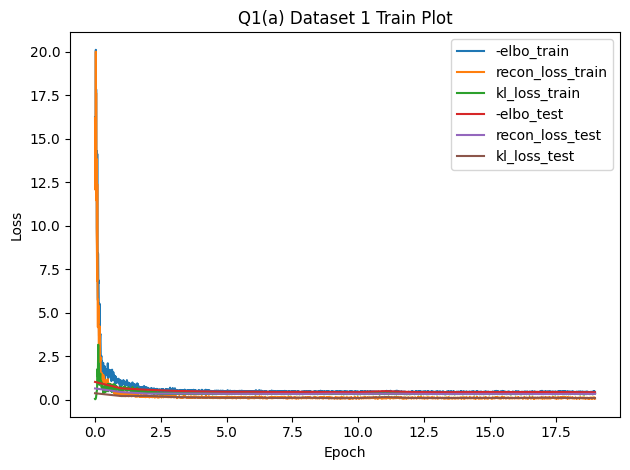

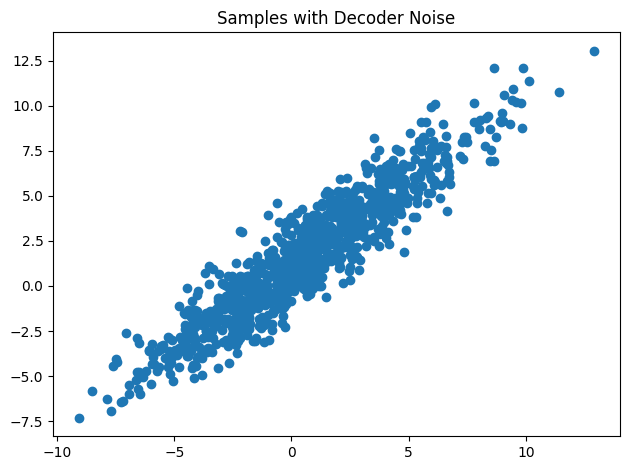

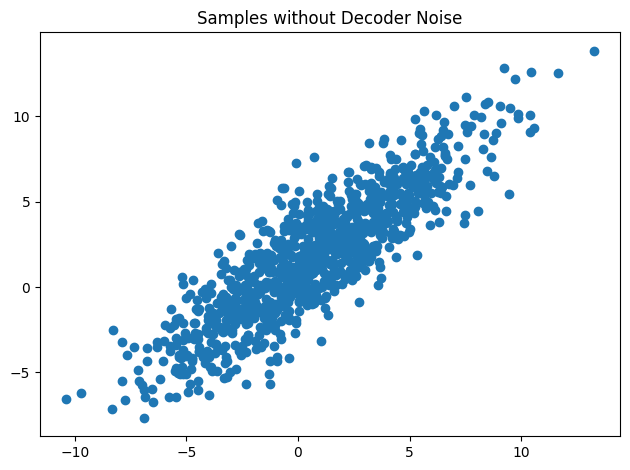

In [ ]:
q1_save_results('a', 1, q1)

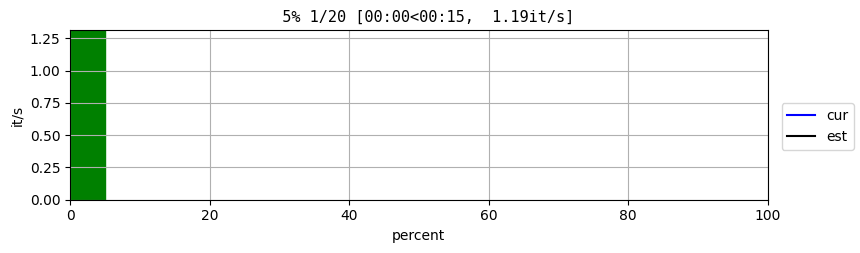

(20, 3)
Final -ELBO: 0.4343, Recon Loss: 0.3412, KL Loss: 0.0931


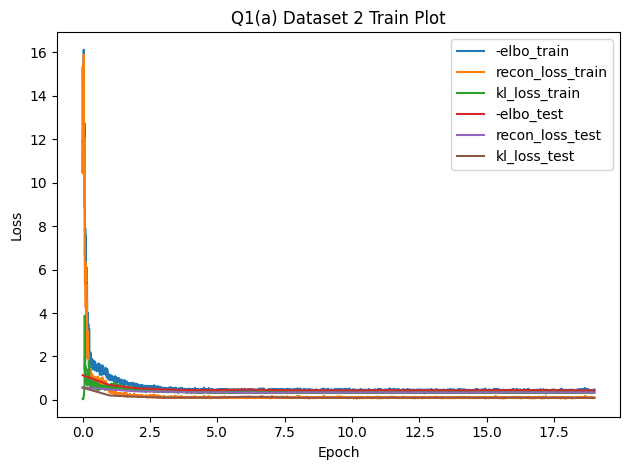

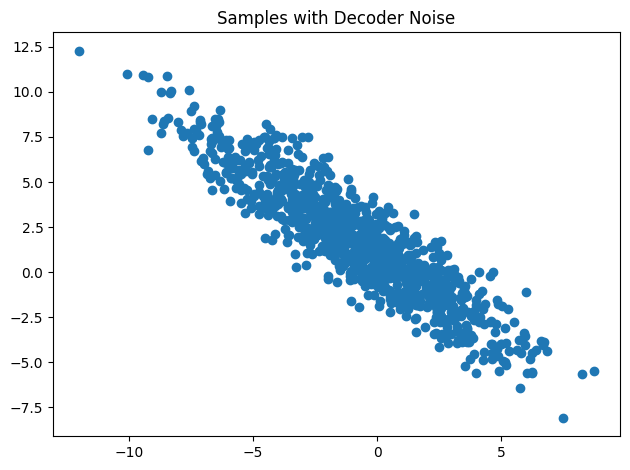

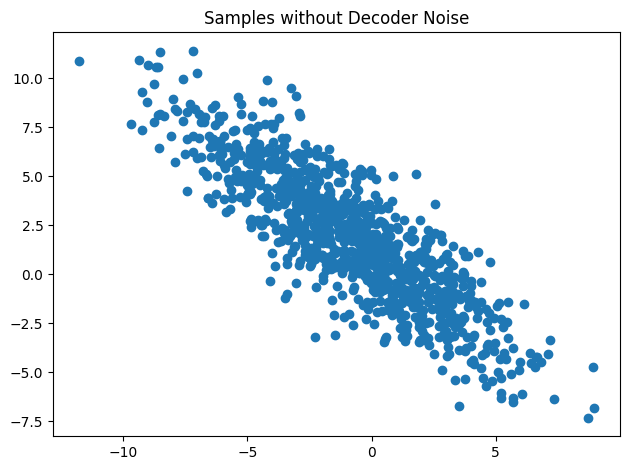

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


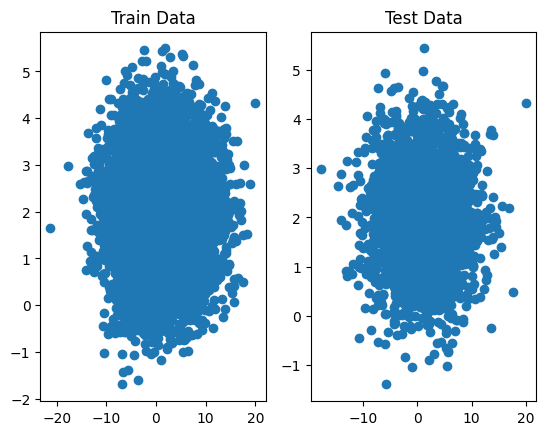

Dataset 2


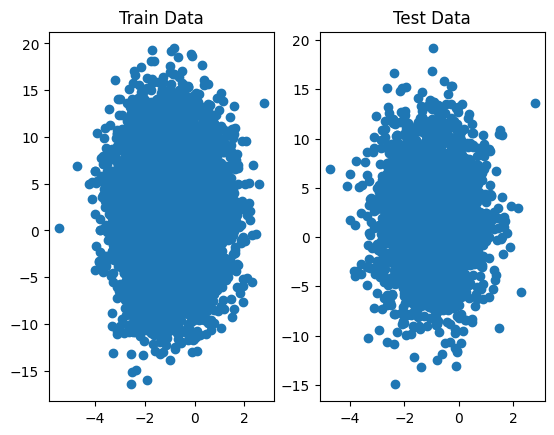

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

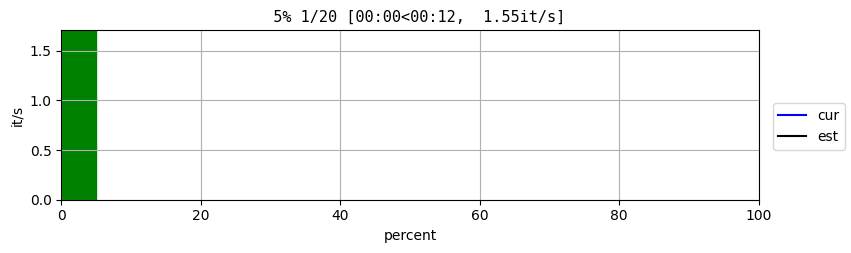

(20, 3)
Final -ELBO: 0.4422, Recon Loss: 0.3347, KL Loss: 0.1075


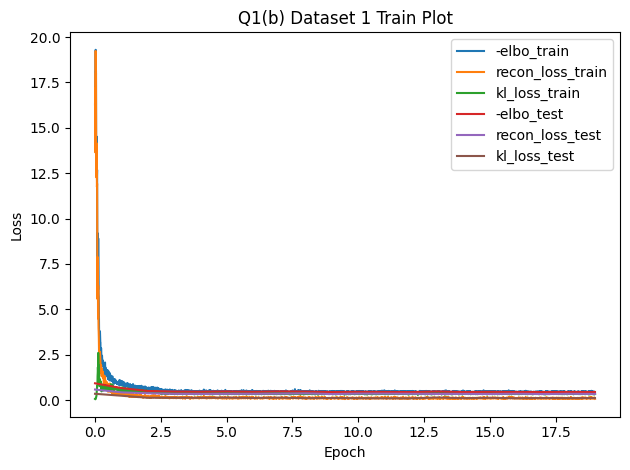

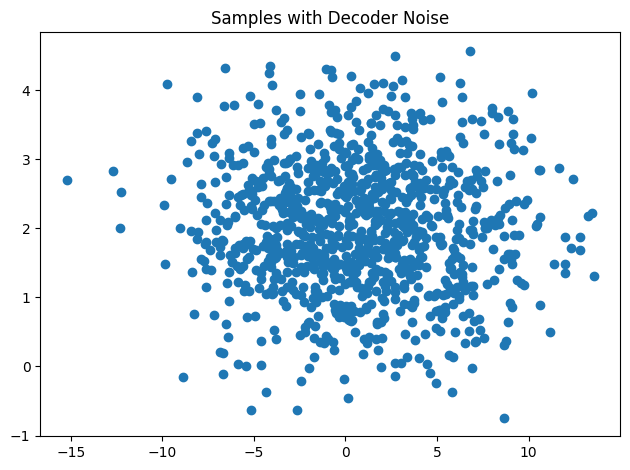

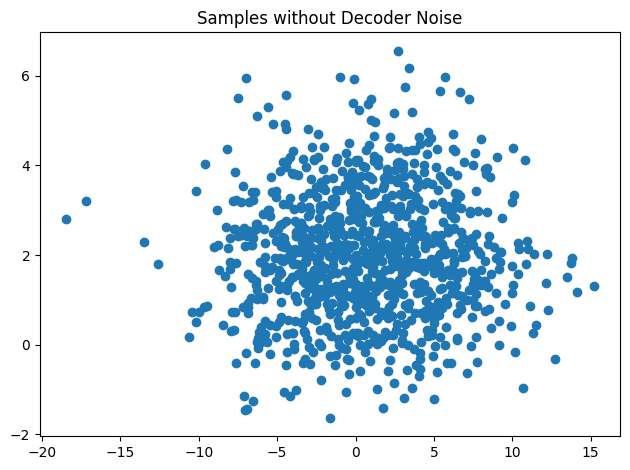

In [ ]:
q1_save_results('b', 1, q1)

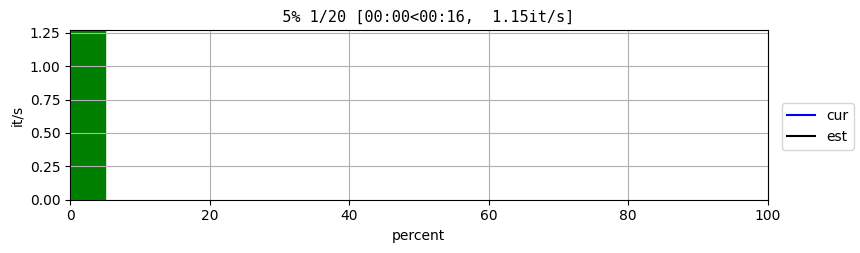

(20, 3)
Final -ELBO: 0.4415, Recon Loss: 0.3370, KL Loss: 0.1045


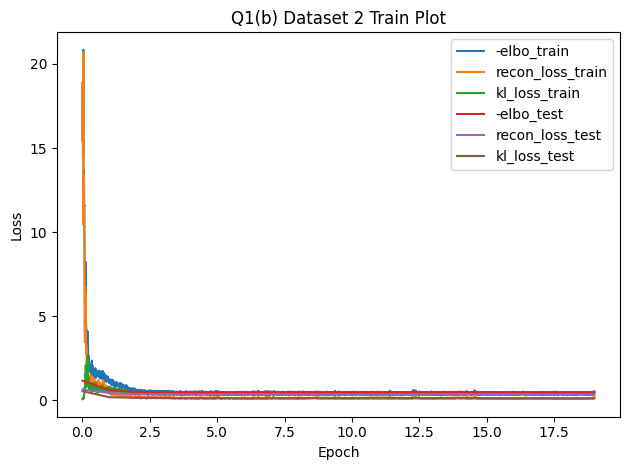

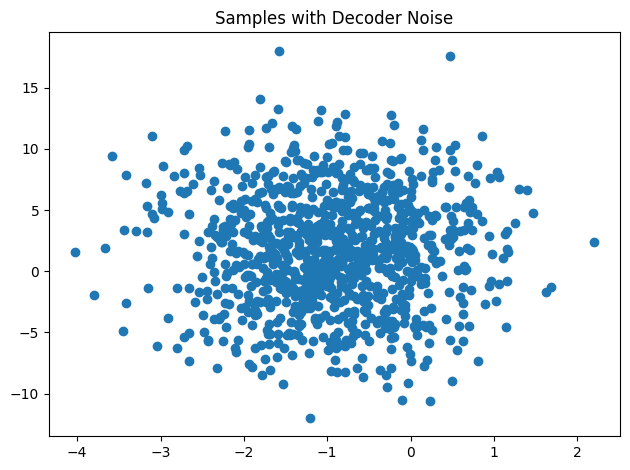

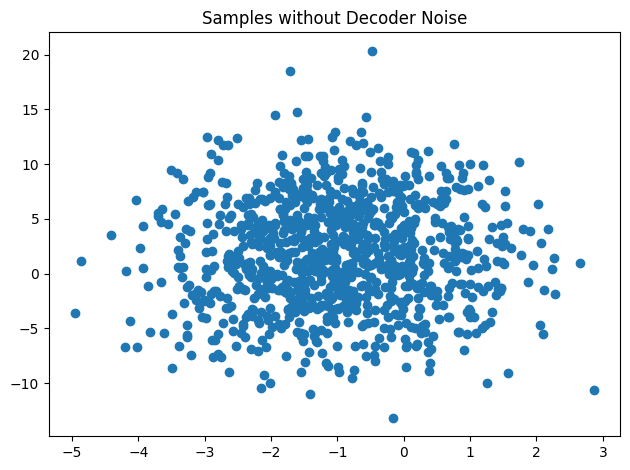

In [ ]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

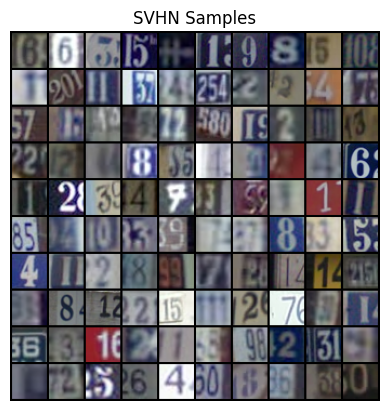

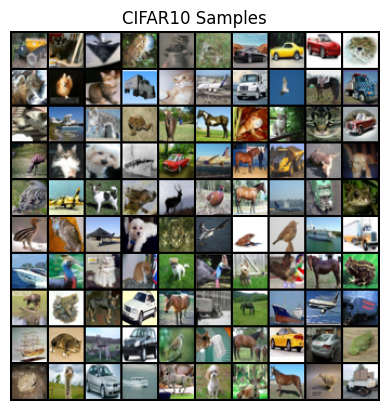

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class Conv_Encoder(nn.Module):
    def __init__(self, latent_dim):
        # super(Encoder, self).__init__()
        super().__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1), # [32, 32, 32]
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, 2, 1),
          nn.ReLU(),
          nn.Conv2d(64, 128, 3, 2, 1),
          nn.ReLU(),
          nn.Conv2d(128, 256, 3, 2, 1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        )
        self.mean_pre = nn.Linear(latent_dim, latent_dim)
        self.logstd_pre = nn.Linear(latent_dim, latent_dim)
    def forward(self, x):
        net_out = self.net(x)
        mean_head = net_out[:, :self.latent_dim]
        logstd_head = net_out[:, self.latent_dim:]
        # mean = self.mean_pre(mean_head)
        # logstd = self.logstd_pre(logstd_head)
        return mean_head, logstd_head
'''
Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)
'''
class Conv_Decoder(nn.Module):
    def __init__(self, latent_dim):
      super().__init__()
      self.latent_dim = latent_dim
      self.net = nn.Sequential(
          nn.Linear(latent_dim, 4 * 4 * 128),
          nn.Unflatten(1, (128, 4, 4)),
          nn.ConvTranspose2d(128, 128, 4, 2, 1),
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, 4, 2, 1),
          nn.ReLU(),
          nn.Conv2d(32, 3, 3, 1, 1), # bs, 3, 32, 32,
          nn.Sigmoid() # <-- 关键：确保输出在 [0, 1] 范围
      )
    def forward(self, x):
      out = self.net(x)
      return out

'''
Decoder
  linear(latent_dim, 4 * 4 * 128)
  relu()
  reshape(4, 4, 128)
  transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
  relu()
  transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
  relu()
  transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
  relu()
  conv2d(32, 3, 3, 1, 1)
'''

'\nDecoder\n  linear(latent_dim, 4 * 4 * 128)\n  relu()\n  reshape(4, 4, 128)\n  transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8\n  relu()\n  transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16\n  relu()\n  transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32\n  relu()\n  conv2d(32, 3, 3, 1, 1)\n'

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    epoch = 15
    lr = 1e-3
    bs = 128
    latent_dim = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def conv_to_tensor(data):
      tensor_data = torch.from_numpy(data).float().to(device) / 255.0
      tensor_data = tensor_data.permute(0, 3, 1, 2)
      return tensor_data
    train_data_ = conv_to_tensor(train_data)
    test_data_ = conv_to_tensor(test_data)
    train_set = torch.utils.data.TensorDataset(train_data_)
    test_set = torch.utils.data.TensorDataset(test_data_)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False)
    encoder = Conv_Encoder(latent_dim).to(device)
    decoder = Conv_Decoder(latent_dim).to(device)
    train_curves = []
    test_curves = []
    warmup_epochs = 7
    def re_param(x, log_var):
      return x + torch.pow(torch.exp(log_var), 0.5) * torch.randn_like(x)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    #TODO:
    def eval_test(model, dataloader):
      with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        total_rec = 0
        total_kl = 0
        for x in test_loader:
          x = x[0].to(device)
          mean, logvar = model(x)
          z = mean + torch.pow(torch.exp(logvar), 0.5) * torch.randn_like(mean)
          mean_ = decoder(z)
          recon_loss = torch.sum((x - mean_) ** 2)
          kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
          loss = (recon_loss + kl_loss) / bs
          total_loss += loss.item()
          total_rec += recon_loss.item()
          total_kl += kl_loss.item()
        return (total_loss / len(dataloader), total_kl / len(dataloader), total_rec / len(dataloader))

    for i in range(epoch):
      encoder.train()
      decoder.train()
      loop = tqdm.tqdm(train_loader)
      if i < warmup_epochs:
          beta = i / warmup_epochs
      else:
          beta = 1.0
      for x in loop:
        x = x[0].to(device)
        optimizer.zero_grad()
        mean, logvar = encoder(x)
        z = mean + torch.pow(torch.exp(logvar), 0.5) * torch.randn_like(mean)
        mean_ = decoder(z)
        recon_loss = torch.sum((x - mean_) ** 2)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = (recon_loss + kl_loss) / bs
        loop.set_postfix({'loss':loss.item(), 'epoch': i})
        loss.backward()
        optimizer.step()
        train_curves.append((loss.item(),
                  recon_loss.item(),
                  kl_loss.item()))
      test_loss, test_kl, test_rec = eval_test(encoder, test_loader)
      test_curves.append((test_loss, test_kl, test_rec))
    with torch.no_grad():
      encoder.eval()
      decoder.eval()
      input_data = torch.randn(100, latent_dim).to(device)
      gen_img = decoder(input_data)
      gen_img = gen_img * 255 + torch.randn_like(gen_img)
      gen_img = gen_img.cpu().numpy()
      gen_img = gen_img.transpose(0, 2, 3, 1).clip(0, 255)
      #------
      import random
      sample_indices = np.random.choice(len(test_data), 50, replace=False)
      real_images_numpy = test_data[sample_indices]
      sample_img = conv_to_tensor(real_images_numpy)
      sample_mean, sample_logvar = encoder(sample_img)
      sample_z = re_param(sample_mean, sample_logvar)
      reconstruct_img = decoder(sample_z)
      reconstruct_img = torch.concat((sample_img, reconstruct_img), dim=0)
      reconstruct_img = reconstruct_img.cpu().numpy()
      reconstruct_img = (reconstruct_img.transpose(0, 2, 3, 1) * 255).clip(0, 255)
      #-------
      test_iter = iter(test_loader)
      total_img = []
      for i in range(10):
          # 取两张图片作为起点和终点
          # .next() 或者 next() 从迭代器中取出一个批次
          # 我们假设批次大小至少为 2
          images = next(test_iter)
          image_A = images[0][0].unsqueeze(dim=0).to(device) # 取第一张图，并保持 batch 维度
          image_B = images[0][1].unsqueeze(dim=0).to(device) # 取第二张图
          # print(image_B.shape)
          mean_a, _ = encoder(image_A)
          mean_b, _ = encoder(image_B)
          interpolated_z = []
          # for i in range(1, 0.1):
          #   z = mean_a * i + mean_b * (10 - i)
          #   interpolated_z.append(z)
          # z = torch.concat(interpolated_z, dim=0)
          alpha = torch.linspace(0, 1, 10).to(device).reshape(10, 1)
          z = alpha * mean_a + (1 - alpha) * mean_b
          # print(z.shape)
          interpolated_img = decoder(z) * 255
          total_img.append(interpolated_img)
      total_img = torch.concat(total_img, dim=0)
      total_img = total_img.cpu().numpy()
      total_img = (total_img.transpose(0, 2, 3, 1)).clip(0, 255)

    return np.array(train_curves), np.array(test_curves), gen_img, reconstruct_img, total_img




### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

100%|██████████| 573/573 [00:03<00:00, 149.46it/s, loss=11.7, epoch=14]


Final -ELBO: 36.5690, Recon Loss: 1526.0585, KL Loss: 3154.7754


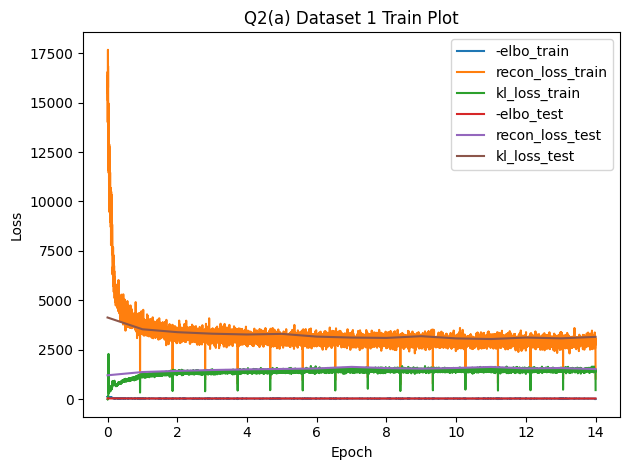

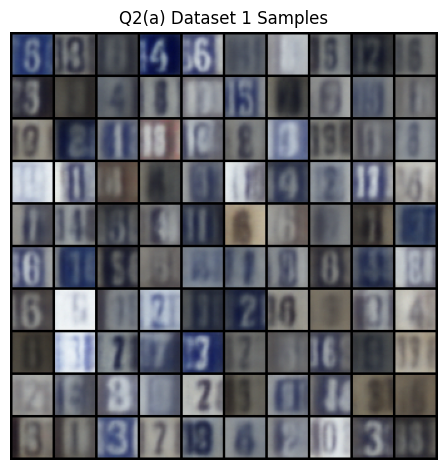

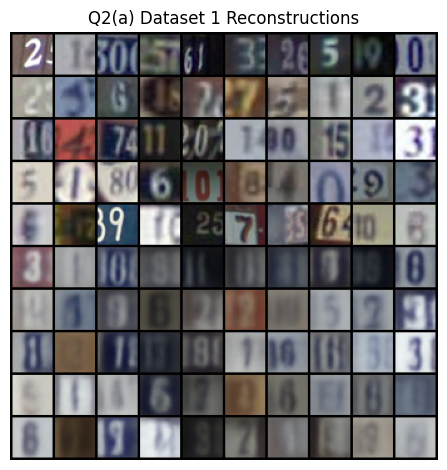

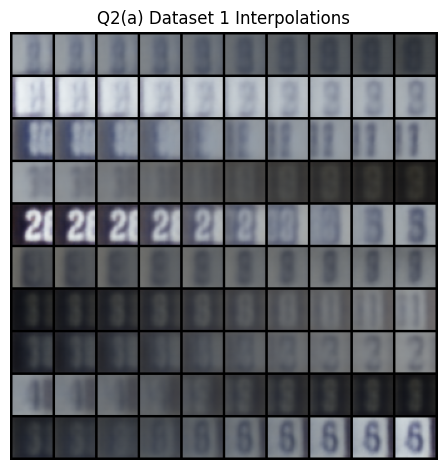

In [ ]:
q2_save_results('a', 1, q2_a) #with sigmoid

100%|██████████| 391/391 [00:02<00:00, 149.73it/s, loss=48.2, epoch=14]


Final -ELBO: 75.7234, Recon Loss: 2306.4065, KL Loss: 7386.1859


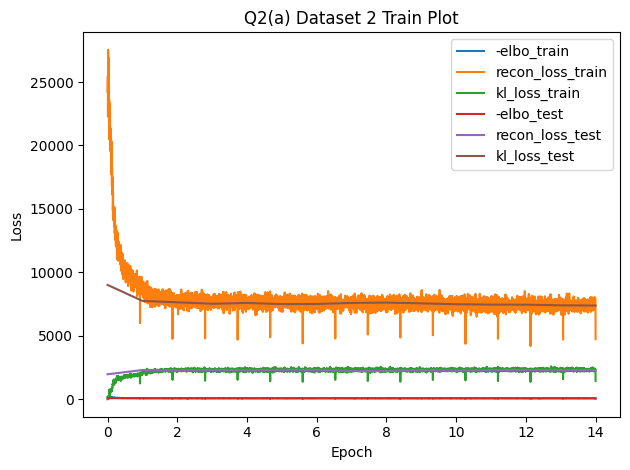

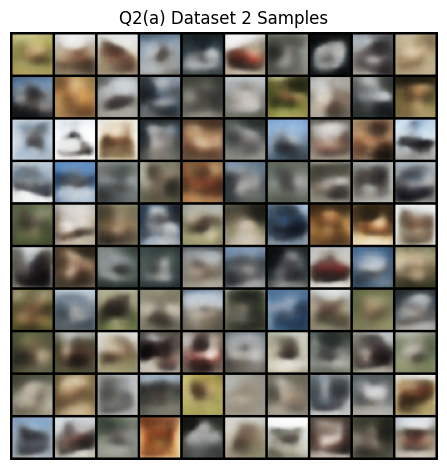

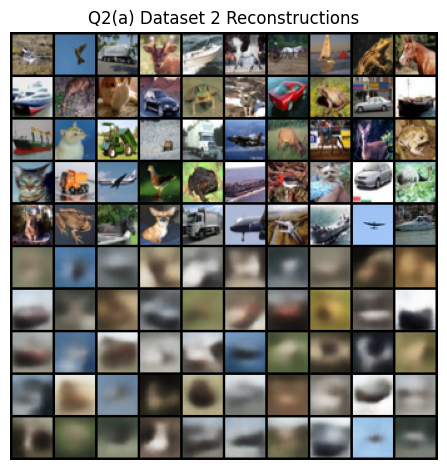

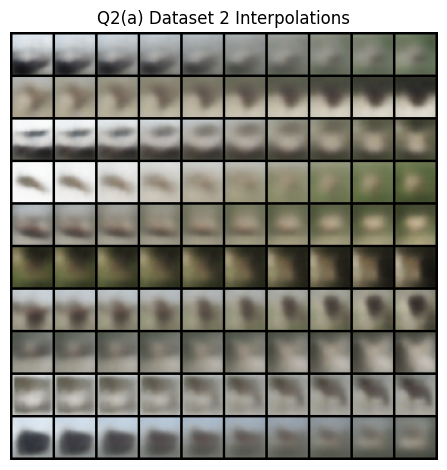

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]




In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class Conv_Encoder(nn.Module):
    def __init__(self, latent_dim):
        # super(Encoder, self).__init__()
        super().__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1), # [32, 32, 32]
          nn.GroupNorm(1, 32),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
          nn.GroupNorm(1, 64),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
          nn.GroupNorm(1, 64),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
          nn.GroupNorm(1, 64),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
          nn.GroupNorm(1, 64),
          nn.ReLU(),
          nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
        )
    def forward(self, x):
        net_out = self.net(x)
        mean_head = net_out[:, :self.latent_dim, :, :]
        logstd_head = net_out[:, self.latent_dim:, :, :]
        # mean = self.mean_pre(mean_head)
        # logstd = self.logstd_pre(logstd_head)
        return mean_head, logstd_head
'''
Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
'''
class Conv_Decoder(nn.Module):
    def __init__(self, latent_dim):
      super().__init__()
      self.latent_dim = latent_dim
      self.net = nn.Sequential(
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
      )
    def forward(self, x):
      out = self.net(x)
      return out

'''
Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
'''
class VAE(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.encoder = Conv_Encoder(latent_dim)
    self.decoder = Conv_Decoder(latent_dim)
    self.z1_to_z2 = nn.Sequential( # [12, 2, 2]
      nn.Conv2d(12, 64, 3, padding=1), # [64, 2, 2]
      nn.ReLU(),
      nn.Conv2d(64, 12, 3, padding=1), # [12, 2, 2]
      nn.ReLU(),
      nn.Conv2d(12, 12, 3, padding=1), # [12, 2, 2]
    )
    self.residual_z2 = nn.Sequential(
      nn.Conv2d(12 + 3, 64, 3, stride=2, padding=1), # [64, 16, 16]
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, stride=2, padding=1), # [12, 8, 8]
      nn.ReLU(),
      nn.Conv2d(64, 64, 5, stride=5, padding=1), # [12, 2, 2]
      nn.ReLU(),
      nn.Conv2d(64, 12 * 2, 3, padding=1), # [12, 2, 2]
    )


In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    epoch = 25
    lr = 1e-3
    bs = 128
    latent_dim = 12
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def conv_to_tensor(data):
      tensor_data = torch.from_numpy(data).float().to(device) / 255.0
      tensor_data = tensor_data.permute(0, 3, 1, 2)
      return tensor_data
    train_data_ = conv_to_tensor(train_data)
    test_data_ = conv_to_tensor(test_data)
    train_set = torch.utils.data.TensorDataset(train_data_)
    test_set = torch.utils.data.TensorDataset(test_data_)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False)
    Vae = VAE(latent_dim).to(device)
    train_curves = []
    test_curves = []
    warmup_epochs = 15
    def re_param(x, log_var):
      return x + torch.pow(torch.exp(log_var), 0.5) * torch.randn_like(x)
    optimizer = torch.optim.Adam(Vae.parameters(), lr=lr)

    def eval_model():
      with torch.no_grad():
        Vae.eval()
        total_loss = 0
        total_rec = 0
        total_kl = 0
        for x in test_loader:
          x = x[0].to(device)
          z1_mean, z1_logvar = Vae.encoder(x)
          # print(z1_mean.shape, z1_logvar.shape)
          z1 = re_param(z1_mean, z1_logvar)
          z1_up_scale = torch.nn.functional.interpolate(z1, scale_factor=16, mode='nearest')
          z2_from_z1 = Vae.z1_to_z2(z1)
          # print(z1_up_scale.shape, x.shape)
          residual_z2 = Vae.residual_z2(torch.concat((z1_up_scale, x), dim=1))
          residual_z2_mean, residual_z2_logstd = torch.chunk(residual_z2, 2, dim = 1)
          residual_sample = re_param(residual_z2_mean, residual_z2_logstd)
          # print(z2_from_z1.shape, residual_sample.shape)
          z2 = z2_from_z1 + residual_sample
          # print(z2.shape)
          recon_img = Vae.decoder(z2)
          recon_loss = torch.sum((x - recon_img) ** 2)
          kl_z2 = torch.sum(-residual_z2_logstd - 0.5 + (torch.exp(2 * residual_z2_logstd) + residual_z2_mean ** 2) * 0.5)
          # print(kl_z2.shape)
          kl_z1 = -0.5 * torch.sum(1 + z1_logvar - z1_mean.pow(2) - z1_logvar.exp())
          loss = (recon_loss + beta * (kl_z1 + kl_z2))
          total_loss += loss.item()
          total_rec += recon_loss.item()
          total_kl += kl_z1.item() + kl_z2.item()
        return (total_loss / len(test_loader), total_rec / len(test_loader), total_kl / len(test_loader))

    for e in range(epoch):
      if e < warmup_epochs:
          beta = e / warmup_epochs * 2
      else:
          beta = 1.0
      Vae.train()
      loop = tqdm.tqdm(train_loader)
      for x in loop:
        x = x[0].to(device)
        optimizer.zero_grad()
        z1_mean, z1_logvar = Vae.encoder(x)
        # print(z1_mean.shape, z1_logvar.shape)
        z1 = re_param(z1_mean, z1_logvar)
        z1_up_scale = torch.nn.functional.interpolate(z1, scale_factor=16, mode='nearest')
        z2_from_z1 = Vae.z1_to_z2(z1)
        # print(z1_up_scale.shape, x.shape)
        residual_z2 = Vae.residual_z2(torch.concat((z1_up_scale, x), dim=1))
        residual_z2_mean, residual_z2_logstd = torch.chunk(residual_z2, 2, dim = 1)
        residual_sample = re_param(residual_z2_mean, residual_z2_logstd)
        # print(z2_from_z1.shape, residual_sample.shape)
        z2 = z2_from_z1 + residual_sample
        # print(z2.shape)
        recon_img = Vae.decoder(z2)
        recon_loss = torch.sum((x - recon_img) ** 2)
        kl_z2 = torch.sum(-residual_z2_logstd - 0.5 + (torch.exp(2 * residual_z2_logstd) + residual_z2_mean ** 2) * 0.5)
        # print(kl_z2.shape)
        kl_z1 = -0.5 * torch.sum(1 + z1_logvar - z1_mean.pow(2) - z1_logvar.exp())
        loss = (recon_loss + kl_z1 + kl_z2) / bs
        loop.set_postfix({'loss':loss.item(), 'epoch': e})
        loss.backward()
        optimizer.step()
        train_curves.append((loss.item(),
                  (recon_loss.item() / bs),
                   (kl_z1 + kl_z2).item() / bs))
      test_curves.append(eval_model())

  #TODO
    with torch.no_grad():
      Vae.eval()
      input_data = torch.randn(100, latent_dim, 2, 2).to(device)
      z_2 = Vae.z1_to_z2(input_data)
      z_2 += torch.randn_like(z_2)
      gen_img = Vae.decoder(z_2)
      gen_img = gen_img * 255
      gen_img = gen_img.cpu().numpy()
      gen_img = gen_img.transpose(0, 2, 3, 1).clip(0, 255)
      #------
      import random
      sample_indices = np.random.choice(len(test_data), 50, replace=False)
      real_images_numpy = test_data[sample_indices]
      sample_img = conv_to_tensor(real_images_numpy)
      sample_mean, sample_logvar = Vae.encoder(sample_img)
      sample_z1 = re_param(sample_mean, sample_logvar)
      sample_z1_up_scale = torch.nn.functional.interpolate(sample_z1, scale_factor=16, mode='nearest')
      sample_z2_from_z1 = Vae.z1_to_z2(sample_z1)
      sample_residual_z2 = Vae.residual_z2(torch.concat((sample_z1_up_scale, sample_img), dim=1))
      z2_mean, z2_logstd = torch.chunk(sample_residual_z2, 2, dim = 1)
      sample_z = sample_z2_from_z1 + re_param(z2_mean, z2_logstd)
      reconstruct_img = Vae.decoder(sample_z)
      reconstruct_img = torch.concat((sample_img, reconstruct_img), dim=0)
      reconstruct_img = reconstruct_img.cpu().numpy()
      reconstruct_img = (reconstruct_img.transpose(0, 2, 3, 1) * 255).clip(0, 255)
      #-------
      test_iter = iter(test_loader)
      total_img = []
      for i in range(10):
          # 取两张图片作为起点和终点
          # .next() 或者 next() 从迭代器中取出一个批次
          # 我们假设批次大小至少为 2
          images = next(test_iter)
          image_A = images[0][0].unsqueeze(dim=0).to(device) # 取第一张图，并保持 batch 维度
          image_B = images[0][1].unsqueeze(dim=0).to(device) # 取第二张图
          # print(image_B.shape)
          mean_a, _ = Vae.encoder(image_A)
          mean_b, _ = Vae.encoder(image_B)
          interpolated_z = []
          alpha = torch.linspace(0, 1, 10).to(device).reshape(10, 1)
          # print(alpha.shape, mean_a.shape, mean_b.shape)
          z1 = torch.einsum('ij, jklm -> iklm', alpha, mean_a) + torch.einsum('ij, jklm -> iklm', 1 - alpha, mean_b)
          z1_up_scale = torch.nn.functional.interpolate(z1, scale_factor=16, mode='nearest')
          z2_from_z1 = Vae.z1_to_z2(z1)
          # z2 = re_param(z2_from_z1 + torch.randn_like(z2_from_z1))
          interpolated_img = Vae.decoder(z2_from_z1) * 255
          total_img.append(interpolated_img)
      total_img = torch.concat(total_img, dim=0)
      total_img = total_img.cpu().numpy()
      total_img = (total_img.transpose(0, 2, 3, 1)).clip(0, 255)

    return np.array(train_curves), np.array(test_curves), gen_img, reconstruct_img, total_img




### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

100%|██████████| 573/573 [00:06<00:00, 92.04it/s, loss=12.3, epoch=24]


Final -ELBO: 5057.5410, Recon Loss: 3747.9079, KL Loss: 1309.6331


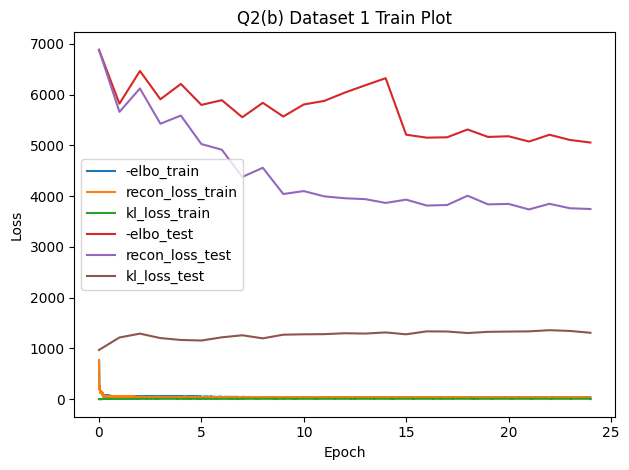

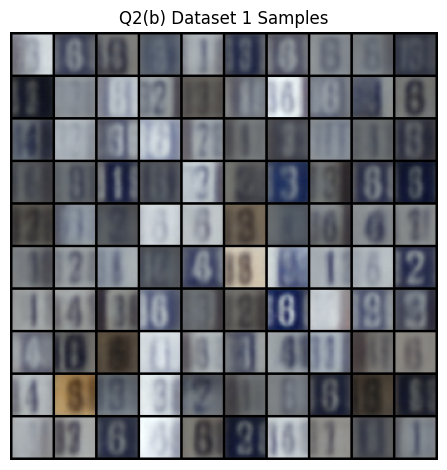

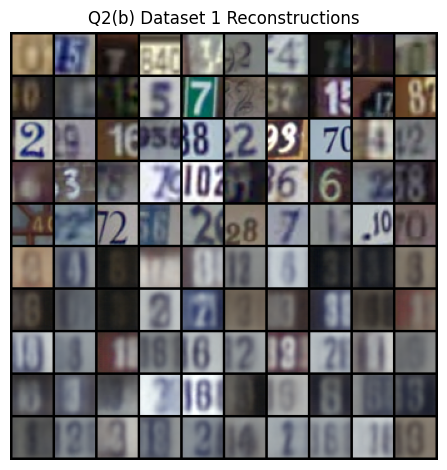

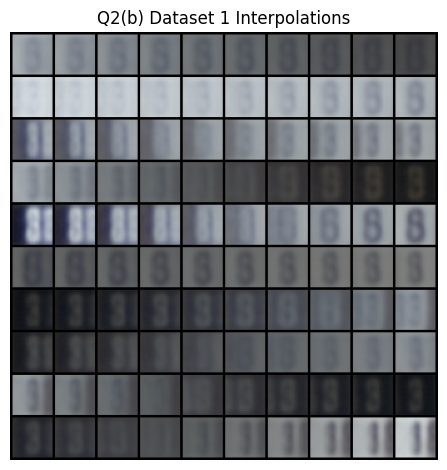

In [ ]:
q2_save_results('b', 1, q2_b)

100%|██████████| 391/391 [00:04<00:00, 91.80it/s, loss=52.6, epoch=24]


Final -ELBO: 10452.5577, Recon Loss: 8135.7406, KL Loss: 2316.8171


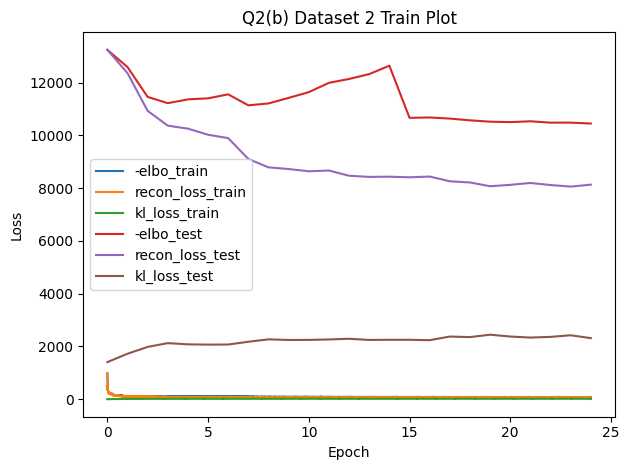

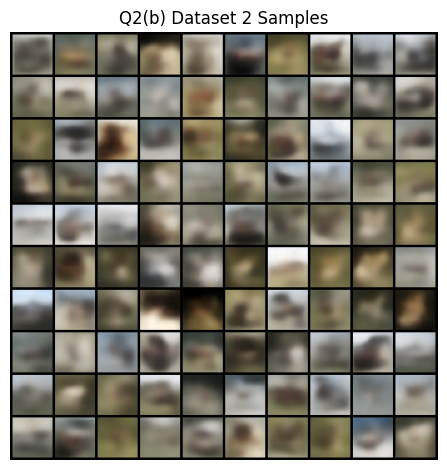

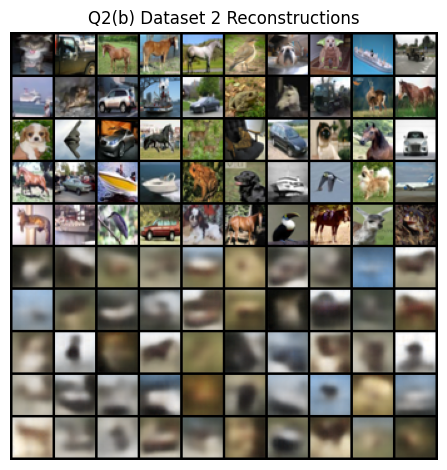

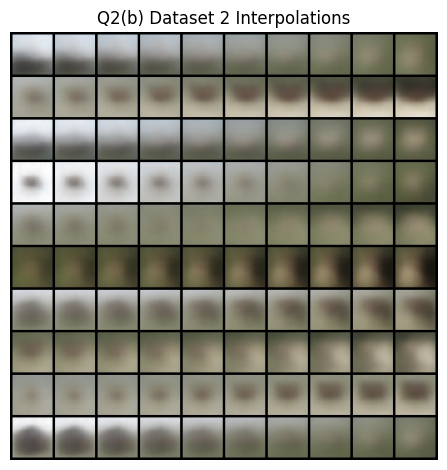

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class residual_block(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.BatchNorm2d(dim),
      nn.ReLU(),
      nn.Conv2d(dim, dim, 3, 1, 1),
      nn.BatchNorm2d(dim),
      nn.ReLU(),
      nn.Conv2d(dim, dim, 1, 1, 0),
    )

  def forward(self, x):
    return x + self.net(x)


class encoder(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(3, 256, 4, 2, 1), # 16 x 16
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256, 256, 4, 2, 1), #8 x 8
      residual_block(256),
      residual_block(256)
    )
  def forward(self, x):
    return self.net(x)

class decoder(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.net = nn.Sequential(
      residual_block(256),
      residual_block(256),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.ConvTranspose2d(256, 256, 4, 2, 1), # 16 x 16
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.ConvTranspose2d(256, 3, 4, 2, 1), # 32 x 32
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.net(x)

class vae(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.encoder = encoder(dim)
    self.decoder = decoder(dim)
    self.codebook = nn.Embedding(128, 256)
    self.codebook.weight.data.uniform_(-1/128, 1/128)


'''
residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32

'''

'\nresidual_block(dim)\n    batch_norm2d(dim)\n    relu()\n    conv2d(dim, dim, 3, 1, 1)\n    batch_norm2d(dim)\n    relu()\n    conv2d(dim, dim, 1, 1, 0)\n\nEncoder\n    conv2d(3, 256, 4, 2, 1) 16 x 16\n    batch_norm2d(256)\n    relu()\n    conv2d(256, 256, 4, 2, 1) 8 x 8\n    residual_block(256)\n    residual_block(256)\n\nDecoder\n    residual_block(256)\n    residual_block(256)\n    batch_norm2d(256)\n    relu()\n    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16\n    batch_norm2d(256)\n    relu()\n    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32\n\n'

In [ ]:
import tqdm
class MHA(nn.Module):
  def __init__(self, num_head = 4, model_dim = 128, vocab_dim = 128):
    super().__init__()
    self.q = nn.Linear(vocab_dim, model_dim)
    self.k = nn.Linear(vocab_dim, model_dim)
    self.v = nn.Linear(vocab_dim, model_dim)
    self.proj = nn.Linear(model_dim, vocab_dim)
    self.num_head = num_head
    self.model_dim = model_dim
    self.vocab_dim = vocab_dim

  def forward(self, x, mask, use_kv = False, k_cache = None, v_cache = None): # x: bs, seq_len, vocab_emb
    q = self.q(x).reshape(x.shape[0], x.shape[1], self.num_head, self.model_dim // self.num_head).transpose(1, 2)
    k = self.k(x).reshape(x.shape[0], x.shape[1], self.num_head, self.model_dim // self.num_head).transpose(1, 2)
    v = self.v(x).reshape(x.shape[0], x.shape[1], self.num_head, self.model_dim // self.num_head).transpose(1, 2) # bs, num_head, seq_len,  head_dim
    if use_kv and k_cache != None:
      k = torch.concat([k_cache, k], dim = 2)
      v = torch.concat([v_cache, v], dim = 2) # change k and v to new and full k, v
    else:
      mask = mask[:v.shape[-2], :v.shape[-2]]
    qk = torch.einsum('b n l d, b n j d -> b n l j', q, k) # b, n, l, l // if use cache qk.shape = b, n, 1, l + 1
    qk = qk + mask
    qk = torch.softmax(qk / (self.model_dim // self.num_head) ** 0.5, dim=-1)
    att = torch.einsum('b n l j, b n j d -> b n l d', qk, v) # b, n, l, d // use cache b, n, 1, d
    att = att.transpose(1, 2).reshape(x.shape[0], x.shape[1], self.model_dim) #b, l , dim
    att = self.proj(att) # b , l, vocab_dim
    if use_kv:
      return att, k, v # return new k and v
    return att

class Transformer_block(nn.Module):
  def __init__(self, heads, model_dim, vocab_dim):
    super().__init__()
    self.mha = MHA(heads, model_dim, vocab_dim)
    self.ffn = nn.Sequential(
      nn.Linear(vocab_dim, vocab_dim * 4),
      nn.GELU(),
      nn.Linear(vocab_dim * 4, vocab_dim)
    )
    self.ln1 = nn.LayerNorm(vocab_dim)
    self.ln2 = nn.LayerNorm(vocab_dim)
  def forward(self, x, mask, use_cache = False, k_cache = None, v_cache = None): # x: bs, seq_len, dim
    x = x
    if use_cache:
      cur_x, k, v = self.mha(self.ln1(x), mask, use_cache, k_cache, v_cache)
      x = x + cur_x
      x = x + self.ffn(self.ln2(x))
      return x, k, v
    else:
      x = x + self.mha(self.ln1(x), mask)
      x = x + self.ffn(self.ln2(x))
      return x

class Transformer(nn.Module):
  def __init__(self, heads = 4, layers = 2, model_dim = 128, max_seq_len=1024, vocab_size = 129, vocab_dim = 64):
    super().__init__()
    self.max_len = max_seq_len
    self.vocab_emb = nn.Embedding(vocab_size, vocab_dim)
    self.pos_emb = nn.Embedding(max_seq_len, vocab_dim)
    self.layers = nn.ModuleList()
    for _ in range(layers):
      self.layers.append(Transformer_block(heads, model_dim, vocab_dim))
    self.out = nn.Linear(vocab_dim, vocab_size)

  def forward(self, x, use_cache = False, k_cache = None, v_cache = None):
    x = x.reshape(x.shape[0], -1)
    x = self.vocab_emb(x.long()) #bs, embed
    pos = self.pos_emb(torch.arange(0, self.max_len).to(x.device).unsqueeze(0)) #1, embed
    x = x + pos[:, :x.shape[1]]
    mask = torch.tril(torch.ones(self.max_len, self.max_len)).to(x.device) #d,d
    mask[mask == 0] = -float('inf')
    mask[mask == 1] = 0
    if not use_cache:
      for layer in range(len(self.layers)):
        x = self.layers[layer](x, mask)
      x = self.out(x)
      return x
    elif use_cache:
      cur_k_cache = []
      cur_v_cache = []
      mask = mask[k_cache[0].shape[2], :v_cache[0].shape[2]+1] # 1, seq_v+1
      for layer in range(len(self.layers)):
        if len(k_cache) != 0 and len(v_cache) != 0:
          x, k, v = self.layers[layer](x, mask, True, k_cache[layer], v_cache[layer])
        else:
          x, k, v = self.layers[layer](x, mask, True)
        cur_k_cache.append(k)
        cur_v_cache.append(v)
      x = self.out(x)
      return x, cur_k_cache, cur_v_cache


In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    epoch = 25
    lr = 1e-4
    bs = 468
    latent_dim = 256
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = 'cpu'
    code_book_tf = Transformer().to(device)
    def conv_to_tensor(data):
      tensor_data = torch.from_numpy(data).float().to(device) / 255.0
      tensor_data = tensor_data.permute(0, 3, 1, 2)
      return tensor_data
    train_data_ = conv_to_tensor(train_data[:])
    test_data_ = conv_to_tensor(test_data[:])
    train_set = torch.utils.data.TensorDataset(train_data_)
    test_set = torch.utils.data.TensorDataset(test_data_)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False)
    Vae = vae(latent_dim).to(device)
    train_curves = []
    test_curves = []
    tf_trian_curves = []
    tf_test_curves = []
    warmup_epochs = 0
    loss_fn1 = torch.nn.MSELoss()
    def re_param(x, log_var):
      return x + torch.pow(torch.exp(log_var), 0.5) * torch.randn_like(x)
    optimizer = torch.optim.Adam(Vae.parameters(), lr=lr)
    def find_in_code_book(z1_flat):
      z1_2 = torch.sum(z1_flat ** 2, dim=1, keepdim=True) # bs * 1
      code_2 = torch.sum(Vae.codebook.weight ** 2, dim=1, keepdim=True).t() # 128 * 1
      code_dim = Vae.codebook.weight
      cal_2ab = -2 * z1_flat @ code_dim.permute(1,0) # bs * 128
      dist = z1_2 + cal_2ab + code_2 # bs * 128
      index = torch.argmin(dist, dim=1) # bs
      return index
    def eval_model():
      with torch.no_grad():
        Vae.eval()
        total_loss = 0
        total_rec = 0
        total_kl = 0
        for x in test_loader:
          x = x[0].to(device)
          z1_raw = Vae.encoder(x) # bs , 256, 8, 8
          '''
          这是最核心的技巧。我们要计算 z_e_flat (形状 [N, D], 其中 N=B*H*W, D=256) 中每个向量，与码本 embedding (形状 [K, D], 其中 K=128) 中所有向量的距离。
          我们将使用平方欧氏距离的展开式 (a-b)² = a² - 2ab + b² 来进行高效计算。
          '''
          z1_flat = z1_raw.permute(0,2,3,1).reshape(-1, 256) # bs * 256
          index = find_in_code_book(z1_flat)
          z1 = Vae.codebook(index) # bs * 8 * 8 , 256
          z1 = z1.reshape(x.shape[0], 8, 8, 256).permute(0, 3, 1, 2)
          z1_for_encoder = (z1 - z1_raw).detach() + z1_raw
          recon_img = Vae.decoder(z1_for_encoder) #bs, 3, 32, 32
          # recon_loss = torch.sum((x - recon_img) ** 2)
          # vq_loss = torch.sum((z1_raw.detach() - z1) ** 2)
          # Commitment_loss = beta * torch.sum((z1_raw - z1.detach()) ** 2)
          recon_loss = loss_fn1(x, recon_img)
          vq_loss = loss_fn1(z1_raw.detach(), z1)
          Commitment_loss = beta * loss_fn1(z1_raw, z1.detach())
          loss = (recon_loss + vq_loss + Commitment_loss)
          total_loss += loss.item()
          # total_rec += recon_loss.item()
          # total_kl += vq_loss.item() + Commitment_loss.item()
        return total_loss / len(test_loader.dataset)
    beta = 0.25
    for e in range(epoch):
    #   if e < warmup_epochs:
    #       beta = e / warmup_epochs * 2
    #   else:
    #       beta = 1.0
      Vae.train()
      loop = tqdm.tqdm(train_loader)
      for x in loop:
        x = x[0].to(device)
        optimizer.zero_grad()
        z1_raw = Vae.encoder(x)
        # print(z1_mean.shape, z1_logvar.shape)
        z1_flat = z1_raw.permute(0,2,3,1).reshape(-1, 256) # bs * 256
        index = find_in_code_book(z1_flat)
        z1 = Vae.codebook(index) # bs * 8 * 8 , 256
        z1 = z1.reshape(x.shape[0], 8, 8, 256).permute(0, 3, 1, 2)
        z1_for_encoder = (z1 - z1_raw).detach() + z1_raw
        recon_img = Vae.decoder(z1_for_encoder) #bs, 3, 32, 32
        # recon_loss = torch.sum((x - recon_img) ** 2)
        # vq_loss = torch.sum((z1_raw.detach() - z1) ** 2)
        # Commitment_loss = beta * torch.sum((z1_raw - z1.detach()) ** 2)
        recon_loss = loss_fn1(x, recon_img)
        vq_loss = loss_fn1(z1_raw.detach(), z1)
        Commitment_loss = beta * loss_fn1(z1_raw, z1.detach())
        loss = (recon_loss + vq_loss + Commitment_loss)
        loop.set_postfix({'loss':loss.item(), 'epoch': e})
        loss.backward()
        optimizer.step()
        train_curves.append(loss.item())
        # train_curves.append((loss.item(),
        #           (recon_loss.item() / bs),
        #            (kl_z1 + kl_z2).item() / bs))
      test_curves.append(eval_model())

  # train transformer
    loss_fn = nn.CrossEntropyLoss(reduction='mean')

    def eval_tf_model():
      with torch.no_grad():
        code_book_tf.eval()
        Vae.eval()
        total_loss = 0
        loop = tqdm.tqdm(test_loader)
        for x in loop:
          x = x[0].to(device)
          encode_text = Vae.encoder(x)
          z1_flat = encode_text.permute(0,2,3,1).reshape(-1, 256) # bs * 256
          index = find_in_code_book(z1_flat)
          index = index.reshape(x.shape[0], -1)
          bos_token = torch.full((x.shape[0], 1), 128).to(device)
          index = torch.concat([bos_token, index], dim = 1)
          x, y = index[:, :-1], index[:, 1:] # bs, 128
          pred = code_book_tf(x) #bs, 127, vocab_size
          loss = loss_fn(pred.permute(0, 2, 1), y)
          total_loss += loss.item()
        return total_loss / len(test_loader)

    optimizer_tf = torch.optim.Adam(code_book_tf.parameters(), lr=lr)
    for i in range(epoch * 2):
      code_book_tf.train()
      Vae.eval()
      loop = tqdm.tqdm(train_loader)
      for x in loop:
        optimizer_tf.zero_grad()
        x = x[0].to(device)
        z1_raw = Vae.encoder(x)
        z1_flat = z1_raw.permute(0,2,3,1).reshape(-1, 256) # bs * 256
        index = find_in_code_book(z1_flat)
        bos_token = torch.full((x.shape[0], 1), 128).to(device)
        index = index.reshape(x.shape[0], -1)
        # print(index.shape, bos_token.shape)
        index = torch.concat((bos_token, index), dim = 1)
        x, y = index[:, :-1], index[:, 1:] # bs, 64
        pred = code_book_tf(x).permute(0, 2, 1) #bs, vocab_dim, seq
        # pred = torch.softmax(pred.squeeze(), dim = -1)
        # print(pred.shape, y.shape)
        loss = loss_fn(pred.squeeze(), y)
        loss.backward()
        optimizer_tf.step()
        loop.set_postfix({'loss':loss.item(), 'epoch': i})
        tf_trian_curves.append(loss.item())
      tf_test_curves.append(eval_tf_model())
      # ------------
      with torch.no_grad():
        code_book_tf.eval()
        Vae.eval()
        input_data = torch.full((100, 1), 128).to(device)
        out = []
        for i in range(64):
          pred = code_book_tf(input_data)
          pred = torch.softmax(pred.squeeze(), dim = -1) #bs, 1,
          if len(pred.shape) == 2:
            pred = pred.unsqueeze(dim = 1)
          logitis = pred[:, -1, :]
          logitis[:, 128] = 0.0
          pred_token = torch.multinomial(logitis, 1)
          out.append(pred_token)
          input_data = torch.concat((input_data, pred_token[:, -1].unsqueeze(dim=1)) ,dim = 1)
        tf_code = input_data[:, 1:]
        input_z = Vae.codebook(tf_code)
        input_z = input_z.reshape(100, 8, 8, 256).permute(0, 3, 1, 2)
        out = Vae.decoder(input_z)
        out = (out * 255).permute(0, 2, 3, 1)
        out = out.cpu().numpy()
    # -------
    with torch.no_grad():
        import random
        random_index = [random.randint(0, test_data_.shape[0] - 1) for _ in range(50)]
        samples = test_data_[random_index]
        z1_raw = Vae.encoder(samples)
        index = find_in_code_book(z1_raw.permute(0, 2, 3, 1).reshape(-1, 256))
        z1 = Vae.codebook(index)
        z1 = z1.reshape(50, 8, 8, 256).permute(0, 3, 1, 2)
        re_construct = Vae.decoder(z1)
        out_2 = torch.concat([samples, re_construct], dim = 0)
        out_2 = out_2.permute(0, 2, 3, 1) * 255.0
        out_2 = out_2.cpu().numpy()
    return train_curves, test_curves, tf_trian_curves, tf_test_curves, out, out_2



## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

100%|██████████| 56/56 [00:01<00:00, 42.56it/s]


VQ-VAE Final Test Loss: 0.0001
Transformer Prior Final Test Loss: 1.4705


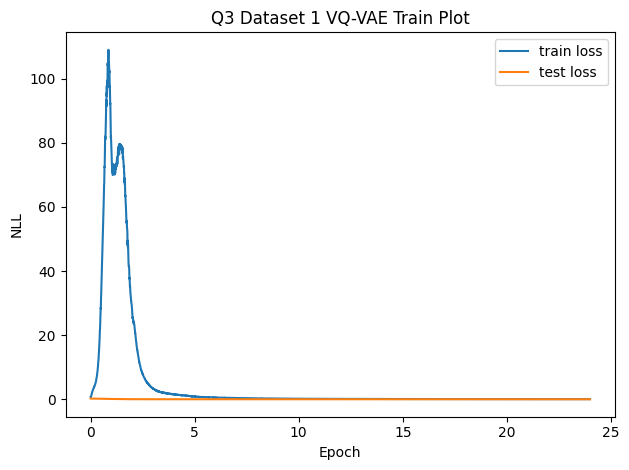

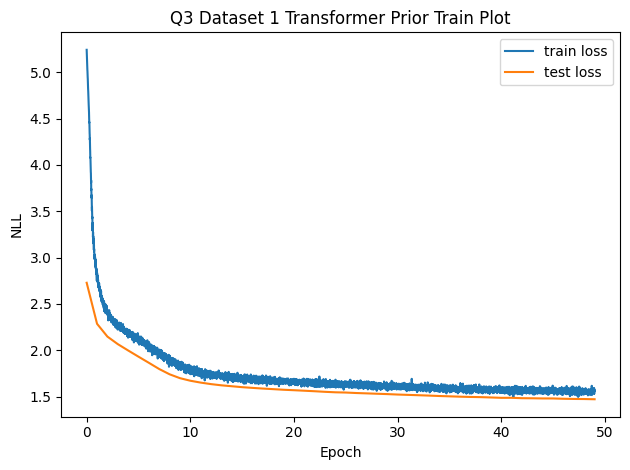

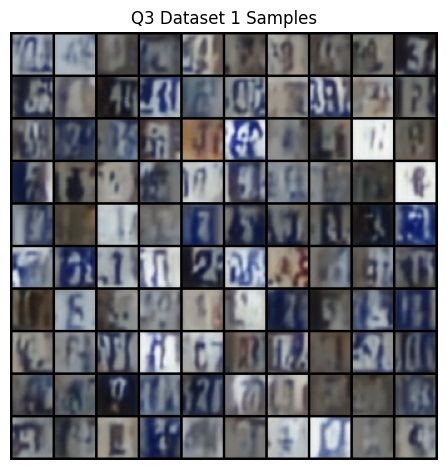

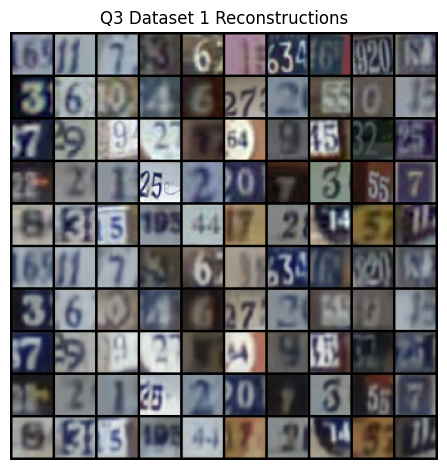

In [ ]:
q3_save_results(1, q3)

100%|██████████| 22/22 [00:00<00:00, 43.12it/s]


VQ-VAE Final Test Loss: 0.0003
Transformer Prior Final Test Loss: 1.8834


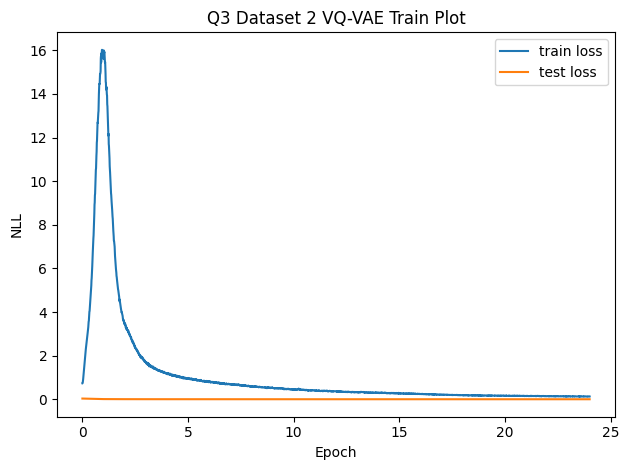

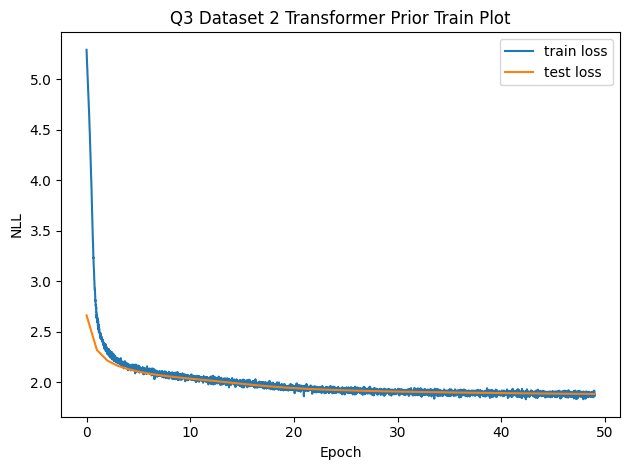

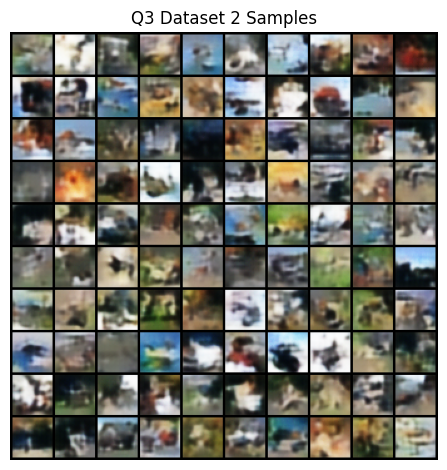

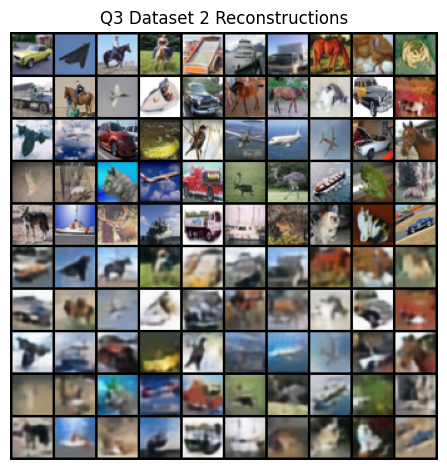

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# @title
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)